# Data Preparation 2

This notebook consist in the second data preparation. Instances of admission Height and Weight measures available corresponding to each ICUSTAY_ID from CHARTEVENTS.db database created in the first notebook (DataPreparation_1) are taken and converted to pandas Dataframe in order to fill the desired features in the main file MAIN_DF.csv. This features are selected via ITEMID. Then Body Mass Index (BMI) is computed from this two features.

This example is the ilustration of the process that will be more automatic in the following notebooks. The goal is to create a rich Dataframe of features for each given admission to the ICU with ICUSTAY_ID identification.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import pylab
matplotlib.style.use('ggplot')

Take the file created in DataPreparation_1

In [2]:
admissions=pd.read_csv('MAIN_DF.csv')
admissions=admissions.drop(['Unnamed: 0'], axis=1)
admissions=admissions.reset_index(drop=True)
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
print('unique ICUSTAY_ID:', admissions.ICUSTAY_ID.nunique())
admissions.head()

(48989, 25)
unique SUBJECT_ID: 36659
unique HADM_ID   : 46273
unique ICUSTAY_ID: 48989


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG
0,3,145834,211552,M,76.53,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,...,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,>4,10.78,>10,0
1,4,185777,294638,F,47.84,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,...,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,1-2,7.76,6-10,0
2,6,107064,228232,F,65.94,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,...,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,2-4,16.36,>10,0
3,9,150750,220597,M,41.79,2149-11-09 13:06:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,...,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,>4,4.88,3-6,1
4,11,194540,229441,F,50.15,2178-04-16 06:18:00,2178-05-11 19:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,SICU,57,57,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,1-2,25.53,>10,0


Define the connexion to the database where we are going to take the desired instances

In [3]:
connex = sqlite3.connect("data/CHARTEVENTS.db")
cur = connex.cursor()

Height in centimeters extraction.

From D_ITEMS.csv file we can link each ITEMID to a measure of a concrete variable or feature

For the Height in centimeters its ITEMID is 226730 (I took the ITEMID with more number of observations)

In [4]:
ids = [226730]
ids = [str(id) for id in ids] 
str_matching = "(" + ",".join(ids) + ")"
print(str_matching)

(226730)


In [5]:
sql = "SELECT * FROM CHARTEVENTS_DB WHERE ITEMID IN " + str_matching + ";"
print('String of SQL   :', sql)
print('Object Execution:', cur.execute(sql))

String of SQL   : SELECT * FROM CHARTEVENTS_DB WHERE ITEMID IN (226730);
Object Execution: <sqlite3.Cursor object at 0x7f6cc8aab500>


In [6]:
df_226730 = pd.read_sql_query(sql, connex)
print(df_226730.shape)
print('unique ICUSTAY_ID:', df_226730.ICUSTAY_ID.nunique())
df_226730.head()

(12015, 15)
unique ICUSTAY_ID: 12011


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,443,34,144319,290505.0,226730,2191-02-23 11:25:00,2191-02-23 11:25:00,15173.0,165.0,165.0,cm,0,0,None,None
1,1981,36,165660,241249.0,226730,2134-05-16 10:58:00,2134-05-16 10:58:00,16223.0,180.0,180.0,cm,0,0,None,None
2,3010,107,174162,264253.0,226730,2122-05-15 23:40:00,2122-05-15 23:40:00,17114.0,168.0,168.0,cm,0,0,None,None
3,3406,109,147469,253139.0,226730,2141-06-11 21:27:00,2141-06-11 21:27:00,17248.0,152.0,152.0,cm,0,0,None,None
4,4328,109,131345,243978.0,226730,2141-09-05 22:15:00,2141-09-05 22:15:00,19937.0,150.0,150.0,cm,0,0,None,None


Units?

In [7]:
df_226730.VALUEUOM.value_counts()

cm    12015
Name: VALUEUOM, dtype: int64

In [8]:
df_226730.isnull().sum()

ROW_ID              0
SUBJECT_ID          0
HADM_ID             0
ICUSTAY_ID          3
ITEMID              0
CHARTTIME           0
STORETIME           0
CGID                0
VALUE               0
VALUENUM            0
VALUEUOM            0
WARNING             0
ERROR               0
RESULTSTATUS    12015
STOPPED         12015
dtype: int64

In [9]:
df_226730=df_226730[df_226730['ERROR']==0]
df_226730=df_226730.drop(['ROW_ID', 'ITEMID', 'STORETIME', 'CGID', 'VALUENUM', 'VALUEUOM', 'WARNING', 
                                'ERROR', 'RESULTSTATUS', 'STOPPED'], axis=1)

In [10]:
df_226730=df_226730.rename({'CHARTTIME':'HEIGHT_T', 'VALUE':'HEIGHT'}, axis='columns')
print(df_226730.shape)
df_226730.head()

(12015, 5)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,HEIGHT_T,HEIGHT
0,34,144319,290505.0,2191-02-23 11:25:00,165.0
1,36,165660,241249.0,2134-05-16 10:58:00,180.0
2,107,174162,264253.0,2122-05-15 23:40:00,168.0
3,109,147469,253139.0,2141-06-11 21:27:00,152.0
4,109,131345,243978.0,2141-09-05 22:15:00,150.0


Merge with the original file conserving the keys of the original file. This is because the second new file doesn't contain values for some ICUSTAY_ID

In [11]:
admissions=pd.merge(admissions,df_226730,how='left',on=['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID'])
print(admissions.shape)
admissions=admissions.sort_values(by=['HEIGHT_T'])
admissions=admissions.reset_index(drop=True)
admissions.head()

(48989, 27)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,LAST_WARDID,INTIME,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG,HEIGHT_T,HEIGHT
0,41552,120254,268176,M,72.11000,2100-07-05 13:52:00,2100-07-08 15:45:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,...,52,2100-07-06 13:59:09,2100-07-07 15:11:01,1.0499,1-2,3.08,3-6,0,2100-07-06 16:04:00,157.0
1,31288,136246,250905,F,91.39889,2100-07-16 11:29:00,2100-07-22 18:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,...,14,2100-07-16 11:30:04,2100-07-17 16:31:25,1.2093,1-2,6.27,6-10,0,2100-07-16 17:15:00,160.0
2,71582,101422,218983,M,76.48000,2100-07-16 18:09:00,2100-07-24 20:07:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,...,12,2100-07-20 09:07:25,2100-07-21 11:03:26,1.0806,1-2,8.08,6-10,0,2100-07-20 11:21:00,160.0
3,31263,198779,278147,M,18.54000,2100-07-18 23:51:00,2100-07-27 12:54:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,14,2100-07-18 23:52:23,2100-07-23 16:49:17,4.7062,>4,8.54,6-10,0,2100-07-20 16:43:00,168.0
4,51754,153020,235889,M,45.05000,2100-07-27 18:12:00,2100-07-31 01:25:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,...,23,2100-07-27 18:13:04,2100-07-31 13:25:27,3.8003,2-4,3.30,3-6,0,2100-07-27 18:37:00,188.0


In [12]:
admissions=admissions.drop_duplicates('ICUSTAY_ID')

In [13]:
admissions.shape

(48989, 27)

Weight admission in kilograms extraction

In [14]:
ids = [226512]
ids = [str(id) for id in ids] 
str_matching = "(" + ",".join(ids) + ")"
print(str_matching)

(226512)


In [15]:
sql = "SELECT * FROM CHARTEVENTS_DB WHERE ITEMID IN " + str_matching + ";"
print('String of SQL   :', sql)
print('Object Execution:', cur.execute(sql))

String of SQL   : SELECT * FROM CHARTEVENTS_DB WHERE ITEMID IN (226512);
Object Execution: <sqlite3.Cursor object at 0x7f6cc8aab500>


In [16]:
df_226512 = pd.read_sql_query(sql, connex)
print(df_226512.shape)
print('unique ICUSTAY_ID:', df_226512.ICUSTAY_ID.nunique())
df_226512.head()

(22604, 15)
unique ICUSTAY_ID: 22597


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,355,34,144319,290505.0,226512,2191-02-23 07:44:00,2191-02-23 07:44:00,17741.0,74.5,74.5,kg,0,0,None,None
1,8,23,124321,234044.0,226512,2157-10-21 12:15:00,2157-10-21 12:15:00,16978.0,66.8,66.8,kg,0,0,None,None
2,1978,36,165660,241249.0,226512,2134-05-16 10:58:00,2134-05-16 10:58:00,16223.0,106.2,106.2,kg,0,0,None,None
3,2029,85,112077,291697.0,226512,2167-07-25 21:31:00,2167-07-25 21:31:00,21050.0,98.0,98.0,kg,0,0,None,None
4,2505,107,182383,252542.0,226512,2121-12-01 05:54:00,2121-12-01 05:54:00,16526.0,88.6,88.6,kg,0,0,None,None


In [17]:
df_226512.VALUEUOM.value_counts()

kg    22604
Name: VALUEUOM, dtype: int64

Weight admission in lb extraction and convert to Kg (we want more observations)

In [18]:
ids = [226531]
ids = [str(id) for id in ids] 
str_matching = "(" + ",".join(ids) + ")"
sql = "SELECT * FROM CHARTEVENTS_DB WHERE ITEMID IN " + str_matching + ";"
print('String of SQL   :', sql)
print('Object Execution:', cur.execute(sql))
df_226531 = pd.read_sql_query(sql, connex)
df_226531['VALUE'] = np.round(df_226531['VALUE'].apply(lambda x: x*(0.453592)),1)
print(df_226531.shape)
print('unique ICUSTAY_ID:', df_226531.ICUSTAY_ID.nunique())
df_226531.head()

String of SQL   : SELECT * FROM CHARTEVENTS_DB WHERE ITEMID IN (226531);
Object Execution: <sqlite3.Cursor object at 0x7f6cc8aab500>
(46255, 15)
unique ICUSTAY_ID: 19643


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,356,34,144319,290505.0,226531,2191-02-23 07:44:00,2191-02-23 07:44:00,17741.0,74.3,163.9,None,0,0,None,None
1,268,23,124321,234044.0,226531,2157-10-22 10:43:00,2157-10-22 10:43:00,21253.0,66.7,147.0,None,0,0,None,None
2,666,34,144319,290505.0,226531,2191-02-24 15:10:00,2191-02-24 15:10:00,17166.0,74.3,163.9,None,0,0,None,None
3,441,34,144319,290505.0,226531,2191-02-23 11:25:00,2191-02-23 11:25:00,15173.0,74.3,163.9,None,0,0,None,None
4,1979,36,165660,241249.0,226531,2134-05-16 10:58:00,2134-05-16 10:58:00,16223.0,106.0,233.6,None,0,0,None,None


In [19]:
frames = [df_226512, df_226531]
mmm = pd.concat(frames)
print('unique ICUSTAY_ID:', mmm.ICUSTAY_ID.nunique())

unique ICUSTAY_ID: 23142


In [20]:
mmm=mmm[mmm['ERROR']==0]
mmm=mmm.drop(['ROW_ID', 'ITEMID', 'STORETIME', 'CGID', 'VALUENUM', 'VALUEUOM', 'WARNING', 
                                'ERROR', 'RESULTSTATUS', 'STOPPED'], axis=1)

In [21]:
mmm=mmm.rename({'CHARTTIME':'WEIGHT_T', 'VALUE':'WEIGHT'}, axis='columns')
mmm=mmm.sort_values(by=['WEIGHT_T'])
mmm=mmm.drop_duplicates('ICUSTAY_ID')
print(mmm.shape)
print('unique ICUSTAY_ID:', mmm.ICUSTAY_ID.nunique())
mmm.head()

(23143, 5)
unique ICUSTAY_ID: 23142


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,WEIGHT_T,WEIGHT
16893,82574,118464,202134.0,2100-06-08 00:21:00,74.5
3115,31585,125380,234741.0,2100-07-03 01:49:00,87.0
16269,79168,125272,293960.0,2100-07-06 15:10:00,126.8
8577,41552,120254,268176.0,2100-07-06 16:04:00,74.8
28622,72723,146616,267483.0,2100-07-09 16:18:00,78.8


In [22]:
admissions=pd.merge(admissions,mmm,how='left',on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])
print(admissions.shape)
admissions=admissions.sort_values(by=['WEIGHT_T'])
admissions=admissions.drop_duplicates('ICUSTAY_ID')
admissions=admissions.reset_index(drop=True)
admissions.head()

(48989, 29)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG,HEIGHT_T,HEIGHT,WEIGHT_T,WEIGHT
0,82574,118464,202134,M,56.120000,2100-06-07 19:59:00,2100-06-09 17:09:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,...,2100-06-08 14:59:31,0.7911,0-1,1.88,0-3,0,NaN,NaN,2100-06-08 00:21:00,74.5
1,31585,125380,234741,M,93.115212,2100-07-02 19:28:00,2100-07-07 18:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,...,2100-07-04 01:57:28,1.1458,1-2,4.94,3-6,0,NaN,NaN,2100-07-03 01:49:00,87.0
2,79168,125272,293960,F,60.640000,2100-07-05 15:22:00,2100-07-27 17:00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,REHAB/DISTINCT PART HOSP,...,2100-07-15 13:14:41,8.9252,>4,22.07,>10,0,NaN,NaN,2100-07-06 15:10:00,126.8
3,41552,120254,268176,M,72.110000,2100-07-05 13:52:00,2100-07-08 15:45:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,...,2100-07-07 15:11:01,1.0499,1-2,3.08,3-6,0,2100-07-06 16:04:00,157.0,2100-07-06 16:04:00,74.8
4,72723,146616,267483,M,21.900000,2100-07-09 10:43:00,2100-07-17 15:00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,...,2100-07-10 16:19:58,1.1252,1-2,8.18,6-10,0,NaN,NaN,2100-07-09 16:18:00,78.8


In [23]:
a_h=pd.to_datetime(admissions.HEIGHT_T)-pd.to_datetime(admissions.INTIME)
a_w=pd.to_datetime(admissions.WEIGHT_T)-pd.to_datetime(admissions.INTIME)
admissions.HEIGHT_T=np.round(a_h.dt.total_seconds()/86400, 2)
admissions.WEIGHT_T=np.round(a_w.dt.total_seconds()/86400, 2)

In [24]:
admissions[admissions['SUBJECT_ID']==23].sort_values(by=['ICUSTAY_ID'])

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG,HEIGHT_T,HEIGHT,WEIGHT_T,WEIGHT
21835,23,152223,227807,M,71.13,2153-09-03 07:15:00,2153-09-08 19:10:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,...,2153-09-04 15:59:11,1.2641,1-2,5.50,3-6,0,NaN,NaN,NaN,NaN
12214,23,124321,234044,M,75.26,2157-10-18 19:34:00,2157-10-25 14:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,...,2157-10-22 16:08:48,1.1862,1-2,6.77,6-10,0,NaN,NaN,0.02,66.8


In [25]:
admissions[admissions['SUBJECT_ID']==109].sort_values(by=['ICUSTAY_ID'])

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG,HEIGHT_T,HEIGHT,WEIGHT_T,WEIGHT
21904,109,183350,208379,F,20.27,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2137-11-20 22:38:41,6.0769,>4,16.94,>10,0,NaN,NaN,NaN,NaN
8934,109,196721,214027,F,24.93,2142-07-12 15:27:00,2142-07-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2142-07-15 20:45:04,3.2197,2-4,11.13,>10,0,NaN,NaN,0.08,50.1
8937,109,196721,217934,F,24.94,2142-07-12 15:27:00,2142-07-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2142-07-18 20:28:26,1.5276,1-2,11.13,>10,0,NaN,NaN,0.02,50.1
8887,109,151240,219154,F,24.77,2142-05-15 10:45:00,2142-05-18 15:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2142-05-16 10:44:24,0.9986,0-1,3.22,3-6,0,NaN,NaN,0.07,41.9
21910,109,110668,221610,F,23.05,2140-08-25 14:39:00,2140-09-02 18:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2140-08-31 23:34:12,6.3704,>4,8.16,6-10,0,NaN,NaN,NaN,NaN
8795,109,140167,222630,F,24.36,2141-12-18 03:50:00,2141-12-23 19:51:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2141-12-23 01:51:57,4.9176,>4,5.67,3-6,0,1.23,152.0,0.05,47.6
21902,109,175347,231823,F,22.78,2140-05-17 14:27:00,2140-05-20 19:50:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2140-05-19 21:23:15,2.2876,2-4,3.22,3-6,0,NaN,NaN,NaN,NaN
8896,109,102024,232807,F,24.82,2142-05-20 12:59:00,2142-06-05 16:18:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2142-06-03 14:41:49,1.8273,1-2,16.14,>10,0,0.40,152.0,0.17,45.0
8762,109,126055,236124,F,24.19,2141-10-13 23:10:00,2141-11-03 18:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2141-10-25 20:49:04,11.9014,>4,20.82,>10,0,NaN,NaN,0.07,49.6
8784,109,161950,237552,F,24.30,2141-11-24 16:11:00,2141-12-01 19:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2141-11-26 21:51:50,2.2359,2-4,7.12,6-10,0,NaN,NaN,0.08,46.2


In [26]:
admissions=admissions.sort_values(by=['SUBJECT_ID'])
admissions=admissions.reset_index(drop=True)

In [27]:
admissions.isnull().sum()

SUBJECT_ID                  0
HADM_ID                     0
ICUSTAY_ID                  0
GENDER                      0
AGE_AD                      0
ADMITTIME                   0
DISCHTIME                   0
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
ETHNICITY                   0
DIAGNOSIS                   0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME                      0
OUTTIME                     0
LOS                         0
LOS_C                       0
TIMEDELTA                   0
TIMEDELTA_C                 0
HOSPITAL_EXPIRE_FLAG        0
HEIGHT_T                37951
HEIGHT                  37951
WEIGHT_T                27180
WEIGHT                  27180
dtype: int64

In order to fill some NaN we can group by SUBJECT_ID and replace NaN that a given SUBJECT_ID can have for different HADM_ID and/or ICUSTAY_ID for the value of some operation of the available values for a given feature.

For the weight I use the mean, for the height I use the most frequent value (more realistic)

Group by SUBJECT_ID and replace NaN by mean values

But first, replace outliers by NaN

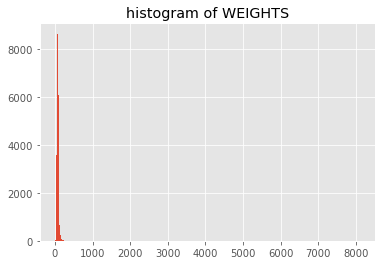

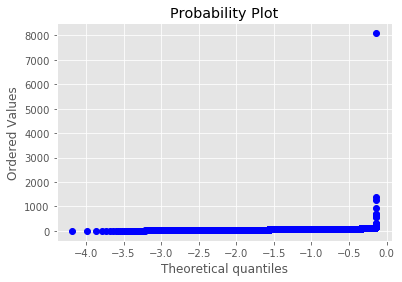

In [28]:
admissions['WEIGHT'].hist(bins=400)
plt.title('histogram of WEIGHTS')
plt.show()
stats.probplot(admissions['WEIGHT'], dist="norm", plot=pylab, rvalue=False)
pylab.show()

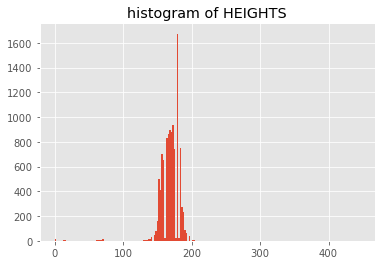

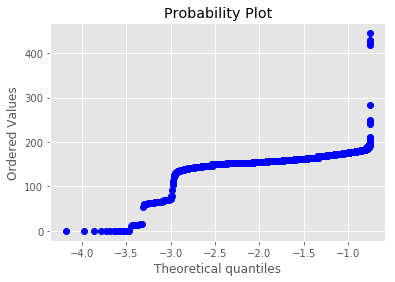

In [29]:
admissions['HEIGHT'].hist(bins=200)
plt.title('histogram of HEIGHTS')
plt.show()
stats.probplot(admissions['HEIGHT'], dist="norm", plot=pylab, rvalue=False)
pylab.show()

In [30]:
admissions['WEIGHT']=admissions['WEIGHT'].mask(admissions['WEIGHT'].abs().gt(175))
admissions['WEIGHT']=admissions['WEIGHT'].mask(admissions['WEIGHT'].abs().lt(20))
admissions['HEIGHT']=admissions['HEIGHT'].mask(admissions['HEIGHT'].abs().gt(220))
admissions['HEIGHT']=admissions['HEIGHT'].mask(admissions['HEIGHT'].abs().lt(140))
#admissions['WEIGHT']=admissions['WEIGHT'].mask(admissions['WEIGHT'].sub(admissions['WEIGHT'].median()).
#                                               div(admissions['WEIGHT'].std()).abs().gt(3))
#admissions['HEIGHT']=admissions['HEIGHT'].mask(admissions['HEIGHT'].sub(admissions['HEIGHT'].median()).
#                                               div(admissions['HEIGHT'].std()).abs().gt(3))

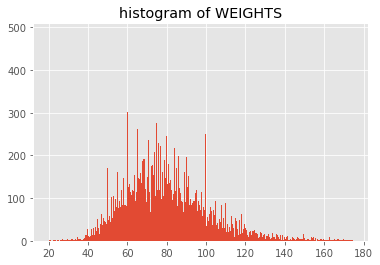

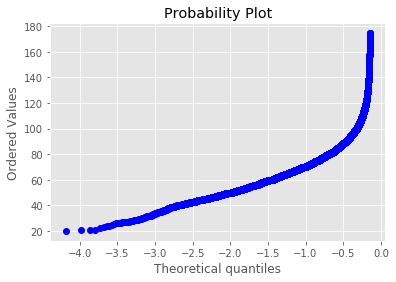

In [31]:
admissions['WEIGHT'].hist(bins=400)
plt.title('histogram of WEIGHTS')
plt.show()
stats.probplot(admissions['WEIGHT'], dist="norm", plot=pylab, rvalue=False)
pylab.show()

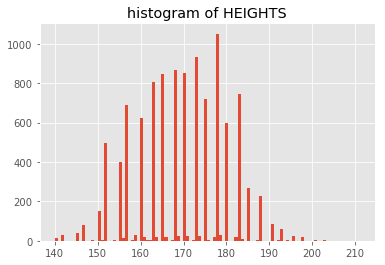

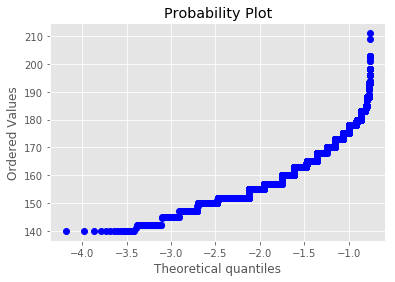

In [32]:
admissions['HEIGHT'].hist(bins=100)
plt.title('histogram of HEIGHTS')
plt.show()
stats.probplot(admissions['HEIGHT'], dist="norm", plot=pylab, rvalue=False)
pylab.show()

In [33]:
admissions.isnull().sum()

SUBJECT_ID                  0
HADM_ID                     0
ICUSTAY_ID                  0
GENDER                      0
AGE_AD                      0
ADMITTIME                   0
DISCHTIME                   0
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
ETHNICITY                   0
DIAGNOSIS                   0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME                      0
OUTTIME                     0
LOS                         0
LOS_C                       0
TIMEDELTA                   0
TIMEDELTA_C                 0
HOSPITAL_EXPIRE_FLAG        0
HEIGHT_T                37951
HEIGHT                  38066
WEIGHT_T                27180
WEIGHT                  27332
dtype: int64

In [34]:
admissions['WEIGHT'] = admissions['WEIGHT'].groupby(admissions['SUBJECT_ID']).transform(
    lambda x: x.fillna(np.round(x.mean(),1)))
admissions['HEIGHT'] = admissions['HEIGHT'].groupby(admissions['SUBJECT_ID']).transform(
    lambda x: x.fillna(x.value_counts().idxmax() if x.value_counts().max() >=1 else x , inplace = False))

In [35]:
admissions.isnull().sum()

SUBJECT_ID                  0
HADM_ID                     0
ICUSTAY_ID                  0
GENDER                      0
AGE_AD                      0
ADMITTIME                   0
DISCHTIME                   0
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
ETHNICITY                   0
DIAGNOSIS                   0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME                      0
OUTTIME                     0
LOS                         0
LOS_C                       0
TIMEDELTA                   0
TIMEDELTA_C                 0
HOSPITAL_EXPIRE_FLAG        0
HEIGHT_T                37951
HEIGHT                  33538
WEIGHT_T                27180
WEIGHT                  24379
dtype: int64

As we can see, we have replaced some NaN by reasonable numbers

In [36]:
admissions[admissions['SUBJECT_ID']==23].sort_values(by=['ICUSTAY_ID'])

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG,HEIGHT_T,HEIGHT,WEIGHT_T,WEIGHT
15,23,152223,227807,M,71.13,2153-09-03 07:15:00,2153-09-08 19:10:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,...,2153-09-04 15:59:11,1.2641,1-2,5.50,3-6,0,NaN,NaN,NaN,66.8
16,23,124321,234044,M,75.26,2157-10-18 19:34:00,2157-10-25 14:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,...,2157-10-22 16:08:48,1.1862,1-2,6.77,6-10,0,NaN,NaN,0.02,66.8


In [37]:
admissions[admissions['SUBJECT_ID']==109].sort_values(by=['ICUSTAY_ID'])

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG,HEIGHT_T,HEIGHT,WEIGHT_T,WEIGHT
95,109,183350,208379,F,20.27,2137-11-04 19:36:00,2137-11-21 18:13:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2137-11-20 22:38:41,6.0769,>4,16.94,>10,0,NaN,152.0,NaN,47.5
90,109,196721,214027,F,24.93,2142-07-12 15:27:00,2142-07-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2142-07-15 20:45:04,3.2197,2-4,11.13,>10,0,NaN,152.0,0.08,50.1
91,109,196721,217934,F,24.94,2142-07-12 15:27:00,2142-07-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2142-07-18 20:28:26,1.5276,1-2,11.13,>10,0,NaN,152.0,0.02,50.1
115,109,151240,219154,F,24.77,2142-05-15 10:45:00,2142-05-18 15:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2142-05-16 10:44:24,0.9986,0-1,3.22,3-6,0,NaN,152.0,0.07,41.9
124,109,110668,221610,F,23.05,2140-08-25 14:39:00,2140-09-02 18:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2140-08-31 23:34:12,6.3704,>4,8.16,6-10,0,NaN,152.0,NaN,47.5
105,109,140167,222630,F,24.36,2141-12-18 03:50:00,2141-12-23 19:51:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2141-12-23 01:51:57,4.9176,>4,5.67,3-6,0,1.23,152.0,0.05,47.6
106,109,175347,231823,F,22.78,2140-05-17 14:27:00,2140-05-20 19:50:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2140-05-19 21:23:15,2.2876,2-4,3.22,3-6,0,NaN,152.0,NaN,47.5
118,109,102024,232807,F,24.82,2142-05-20 12:59:00,2142-06-05 16:18:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,2142-06-03 14:41:49,1.8273,1-2,16.14,>10,0,0.40,152.0,0.17,45.0
114,109,126055,236124,F,24.19,2141-10-13 23:10:00,2141-11-03 18:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2141-10-25 20:49:04,11.9014,>4,20.82,>10,0,NaN,152.0,0.07,49.6
111,109,161950,237552,F,24.30,2141-11-24 16:11:00,2141-12-01 19:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,...,2141-11-26 21:51:50,2.2359,2-4,7.12,6-10,0,NaN,152.0,0.08,46.2


In [38]:
admissions=admissions.drop(['HEIGHT_T', 'WEIGHT_T'], axis=1)
admissions['BMI'] = np.round((admissions['WEIGHT']/(admissions['HEIGHT']*admissions['HEIGHT']/10000)), 1)
#admissions['BMI'] = admissions['BMI'].groupby(admissions['SUBJECT_ID']).transform(lambda x: x.fillna(x.mean()))

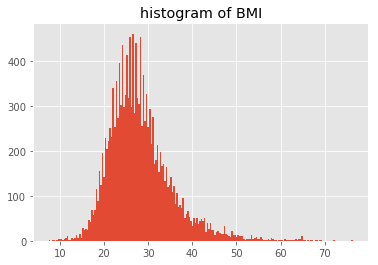

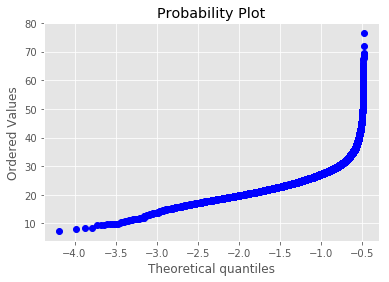

In [39]:
admissions['BMI'].hist(bins=200)
plt.title('histogram of BMI')
plt.show()
stats.probplot(admissions['BMI'], dist="norm", plot=pylab, rvalue=False)
pylab.show()

In [40]:
admissions.isnull().sum()

SUBJECT_ID                  0
HADM_ID                     0
ICUSTAY_ID                  0
GENDER                      0
AGE_AD                      0
ADMITTIME                   0
DISCHTIME                   0
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
ETHNICITY                   0
DIAGNOSIS                   0
DBSOURCE                    0
FIRST_CAREUNIT              0
LAST_CAREUNIT               0
FIRST_WARDID                0
LAST_WARDID                 0
INTIME                      0
OUTTIME                     0
LOS                         0
LOS_C                       0
TIMEDELTA                   0
TIMEDELTA_C                 0
HOSPITAL_EXPIRE_FLAG        0
HEIGHT                  33538
WEIGHT                  24379
BMI                     33613
dtype: int64

In [41]:
admissions.to_csv('MAIN_DF_2.csv')